<a href="https://colab.research.google.com/github/YMGYM/google_colab_files/blob/master/Image_Text_Embedding_with_tokenizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 패키지 임포트

In [ ]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import torch
import torchvision.models as models # 임베딩 모델
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 파일 다운로드 및 압축 해제

In [ ]:
# 리뷰 테이블 읽어오기
review = pd.read_csv('/content/drive/MyDrive/Datasets/img_review_tag_df_final_20210624 (2).csv', encoding='cp949')

In [ ]:
!unzip -O euc-kr -q /content/drive/MyDrive/Datasets/img_preprocess_final_20210624.zip -d data

17번가_1.jpg:  mismatching "local" filename (17踰媛_1.jpg),
         continuing with "central" filename version
17번가_2.jpg:  mismatching "local" filename (17踰媛_2.jpg),
         continuing with "central" filename version
17번가_3.jpg:  mismatching "local" filename (17踰媛_3.jpg),
         continuing with "central" filename version
1945카페_1.jpg:  mismatching "local" filename (1945移댄_1.jpg),
         continuing with "central" filename version
1945카페_2.jpg:  mismatching "local" filename (1945移댄_2.jpg),
         continuing with "central" filename version
1945카페_3.jpg:  mismatching "local" filename (1945移댄_3.jpg),
         continuing with "central" filename version
298카페_1.jpg:  mismatching "local" filename (298移댄_1.jpg),
         continuing with "central" filename version
298카페_2.jpg:  mismatching "local" filename (298移댄_2.jpg),
         continuing with "central" filename version
298카페_3.jpg:  mismatching "local" filename (298移댄_3.jpg),
         continuing with "central" filename 

In [ ]:
# 없는 파일 인덱스 파악
result = []
all_img = [f for f in os.listdir('/content/data') if os.path.isfile(os.path.join('/content/data', f))]

for idx, imgName in enumerate(review['imgname_123']):
  if imgName not in all_img or imgName == 'desktop.ini':
    result.append(idx)


result

[753, 4400, 4568, 5166]

In [ ]:
review.drop(result, inplace=True)
review.dropna(inplace=True)
review = review.reset_index(drop = True)

# soynlp 설치

In [ ]:
!pip install soynlp

     |████████████████████████████████| 419kB 8.0MB/s 


In [ ]:
from soynlp import DoublespaceLineCorpus
from soynlp.word import WordExtractor
from soynlp.tokenizer import LTokenizer
from soynlp.vectorizer import BaseVectorizer

# 기본 클래스 정의

In [ ]:
class CaptionDataset(Dataset):
    """
    root_dir : 이미지 파일이 있는 경로
    captions_file : 이미지 제목-리뷰가 포함된 데이터프레임
    transform : 이미지를 텐서로 변환할 때 transform (optional)
    """
    def __init__(self, img_dir, caption_df, seq_len=15, transform=None):
        self.root_dir = img_dir
        self.transform = transform
        self.df = caption_df
    
        self.imgs = self.df['imgname_123'] # 이미지 파일 경로
        self.captions = self.df["review"] # 리뷰 데이터

        self.seq_len = seq_len
        # soynlp
        self.vectorizer = BaseVectorizer(min_tf=1)
        self.vectorizer.load('/content/drive/MyDrive/koremb_tobigs/vectorizer')
    
    def __len__(self):
        return len(self.df)
    
    # 이미지, 텍스트를 불러 오는 메소드
    # transform을 선언하면 임베딩 벡터와 1개 배치로 반환하며, 선언하지 않으면 이미지와 스트링 형태의 캡션을 반환합니다.
    def __getitem__(self,idx):
        caption = self.captions[idx] # target caption
        
        img_name = self.imgs[idx] # 이미지 이름 파일 불러오기
        img_location = os.path.join(self.root_dir,img_name) # 실제로 이미지 오픈
        img = Image.open(img_location).convert("RGB")
        
        # transform이 있다면 실시 후 배치화(1 차원 추가)
        if self.transform is not None:
          img = self.transform(img)
          # 정답 임베딩 데이터 
          # seq_len을 15로 통일하고자 합니다.
          caption = self.vectorizer.encode_a_doc_to_list(caption)

          if len(caption) > self.seq_len:
            caption = caption[:self.seq_len]
          elif len(caption) < self.seq_len:
            while(len(caption) != self.seq_len):
              caption.append(self.vectorizer.vocabulary_['<PAD>'])
          caption = torch.tensor(caption)
          # caption = F.one_hot(caption, num_classes=len(self.vectorizer.vocabulary_)).type(torch.float)
        return img, caption

In [ ]:
# class overriding
class TobigVectorizer(BaseVectorizer):
  def __init__(self, tokenizer=lambda x:x.split(), min_tf=0,
        max_tf=99999999, min_df=0, max_df=1.0, stopwords=None,
        lowercase=True, verbose=True):
    super().__init__()

  def encode_a_doc_to_list(self, doc):
    # 언노운 토큰으로 반환하도록 오버라이딩
        return [self.vocabulary_[term] if term in self.vocabulary_ else self.vocabulary_["<UNK>"] for term in self.tokenizer(doc) ]
 

In [ ]:
vectorizer = TobigVectorizer(min_tf=1)
vectorizer.load('/content/drive/MyDrive/koremb_tobigs/vectorizer')

In [ ]:
# from https://github.com/bentrevett/pytorch-seq2seq/blob/master/2%20-%20Learning%20Phrase%20Representations%20using%20RNN%20Encoder-Decoder%20for%20Statistical%20Machine%20Translation.ipynb
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, padding_idx):
        super().__init__()
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=padding_idx)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)
        self.fc_out = nn.Linear(emb_dim + hid_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)


    def forward(self, input, hidden, context):
        
        #input = [batch_size]
        input = input.unsqueeze(0) #input = [1, batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #context = [n layers * n directions, batch size, hid dim]
        
        #n layers and n directions in the decoder will both always be 1, therefore:
        #hidden = [1, batch size, hid dim]
        #context = [1, batch size, hid dim]
        
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
        emb_con = torch.cat((embedded, context), dim = 2)
            
        #emb_con = [1, batch size, emb dim + hid dim]
            
        output, hidden = self.rnn(emb_con, hidden)
      
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #seq len, n layers and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), 
                           dim = 1)
        
        #output = [batch size, emb dim + hid dim * 2]
        
        prediction = self.fc_out(output)
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden

In [ ]:
class Net(nn.Module):
  """
  신경망 파일
  hidden_size : kor2vec의 embedding size 로 맞춰야 합니다.
  """
  def __init__(self, seq_len = 15, embedding_size = 64, hidden_size = 64):
    super(Net, self).__init__()
    self.seq_len = seq_len
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.resnet = models.resnet18(pretrained=True)
    

    self.vectorizer = TobigVectorizer(min_tf=1)
    self.vectorizer.load('/content/drive/MyDrive/koremb_tobigs/vectorizer')

    self.decoder = Decoder(len(self.vectorizer.vocabulary_), self.embedding_size, self.hidden_size, 0.5, self.vectorizer.vocabulary_['<PAD>'])

    # resNet의 모든 파라미터를 잠그고 마지막 레이어만 얼리지 않고 사용합니다.
    for param in self.resnet.parameters():
       param.requires_grad = False
    self.resnet.fc = nn.Linear(512, self.hidden_size) # 마지막 레이어만 다시 사용합니다.

  def forward(self, x):
    batch_size = x.shape[0]
    x = self.resnet(x).reshape(1,batch_size,self.hidden_size) # resnet 통과 output: (batch, hidden)

    hidden = x # lstm의 초기 셀 값은 resNet의 출력입니다.
    outputs = torch.zeros(self.seq_len, batch_size, len(self.vectorizer.vocabulary_)).to(device) # sequence를 저장하기 위한 빈 배열
    

    # <sos> 를 시작 토큰으로 설정합니다.
    inputSent = torch.tensor(self.vectorizer.encode_a_doc_to_list("<SOS>")).repeat(batch_size).to(device)
    
  
    # seq 결과물을 lstm의 입력으로 사용하여 seq_len = 15 만큼 반복하여 저장합니다.
    for t in range(0, self.seq_len):
        output, hidden = self.decoder(inputSent, hidden, x ) 
        outputs[t] = output
        inputSent = output.argmax(1)

    return outputs.reshape(batch_size, len(self.vectorizer.vocabulary_), self.seq_len, ) # shape: (15, batch_size, 1000)


  def give_embedding(self, x):  # 원도 추가 부분
    batch_size = x.shape[0]
    x = self.resnet(x).reshape(1,batch_size,self.hidden_size) # resnet 통과 output: (batch, hidden)

    hidden = x # lstm의 초기 셀 값은 resNet의 출력입니다.
    outputs = torch.zeros(self.seq_len, batch_size, len(self.vectorizer.vocabulary_)).to(device) # sequence를 저장하기 위한 빈 배열
    

    # <sos> 를 시작 토큰으로 설정합니다.
    inputSent = torch.tensor(self.vectorizer.encode_a_doc_to_list("<SOS>")).repeat(batch_size).to(device)
    
        
    return hidden
  
  def give_resnet_embedding(self, x):  # 원도 추가 부분
    batch_size = x.shape[0]
    x = self.resnet(x).reshape(1,batch_size,self.hidden_size) # resnet 통과 output: (batch, hidden)

    hidden = x # lstm의 초기 셀 값은 resNet의 출력입니다.
    return hidden


# 모두 불러와서 학습

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), # 텐서로 변형
     transforms.Resize(224), # 사이즈 조절
     transforms.CenterCrop(224), # 가로와 세로 중 안 맞는 곳 자르기
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
train_data = CaptionDataset('/content/data', review, seq_len=25, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model = Net(seq_len=25, embedding_size = 1000, hidden_size = 1000)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model.to(device)

Net(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
# 신경망 학습
model.train()
for epoch in range(2): # 2에포크
  running_loss = 0.0
  for i, data in enumerate(train_dataloader):
    img, label = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    output = model(img)

    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    
    if i>= len(train_dataloader) - 1: break # 왜인지 모르겠으나 묵시적으로 enumerate가 종료되지 않아서 명시적으로 추가
    
    if (i % 10) == 0: # 매 10번 미니배치마다 출력하기
            print('[%d, %5d] loss: %.3f' %
                  (epoch +1, i+1, running_loss / 10))
            running_loss =0.0

[1,     1] loss: 1.024
[1,    11] loss: 8.846
[1,    21] loss: 8.847
[1,    31] loss: 8.594
[1,    41] loss: 8.426
[1,    51] loss: 8.493
[1,    61] loss: 8.631
[2,     1] loss: 0.850
[2,    11] loss: 8.442
[2,    21] loss: 8.335
[2,    31] loss: 8.374
[2,    41] loss: 8.389
[2,    51] loss: 8.486
[2,    61] loss: 8.516


# 모델 평가

In [ ]:
i_list = []
resnet_embed_list = []
embed_list = []

# 모든 이미지에 대한 임베딩 계산
for i, data in enumerate(train_data):
    model.eval()
    
    img, label = data[0].to(device), data[1].to(device)
    img = img.unsqueeze(0)
    resnet_embed = model.give_resnet_embedding(img)[0].cpu().detach().numpy()[0][0]
    embed = model.give_embedding(img)[0].cpu().detach().numpy()[0][0]


    i_list.append(i)
    embed_list.append(embed)
    resnet_embed_list.append(resnet_embed)

    if i>= len(train_data) - 1: break

    if i%1000 == 0:
      print(f"image done : {i}")

image done : 0
image done : 1000
image done : 2000
image done : 3000
image done : 4000
image done : 5000
image done : 6000
image done : 7000
image done : 8000


In [ ]:
img_data = CaptionDataset('/content/data', review, transform=None)

target img : 300
9, 사진에 있는 와플이 4천원 밖에안함 ,,, 대학교 앞이여서 그런지 가성비 갑..<U+0001F44D><U+0001F3FB> 커피는 쏘쏘


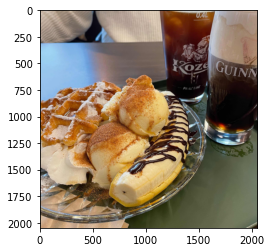

가장 가까운 이미지
0, 사진에 있는 와플이 4천원 밖에안함 ,,, 대학교 앞이여서 그런지 가성비 갑..<U+0001F44D><U+0001F3FB> 커피는 쏘쏘, distance : 0.0


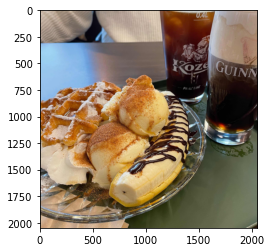

1, 맛나요 갠소카페인대 깨긋하고 젛아요
특히 밀크티 완전 맛나여, distance : 4.673004150390625e-05


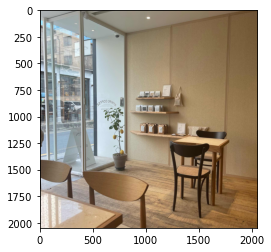

2, 왕십리에서 제일 맘에 드는 카페에요. 빈티지한 분위기에 구석구석 앤티크한 소품들이 예뻐요. 찻잔이랑 주전자도 너무 귀엽고 차도 맛있어요. 사장님 감각이 좋으신 것 같아요. 차도 직접 가져다 주세요. 그리고 엄청 귀여운 고양이가 있습니다ㅠㅠ 완벽, distance : 0.00020962953567504883


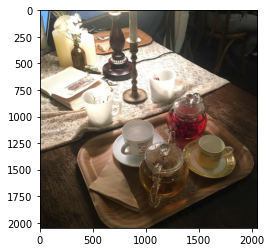

3, 숨은 맛집!! 쉬폰케익이랑 단호박치즈케이크 진짜 맛있어요ㅎㅎ 노버터인것도 맘에 들고 한적한 동네에 있어서 사람도 안많고 조용조용하니 좋았습니다, distance : 0.00026726722717285156


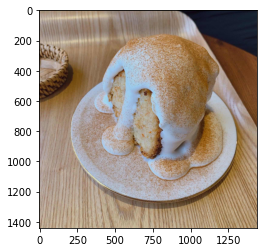

4, 카운터 직원, 사장 모두 불친절 서비스 마인드 최악.
에스프레소 머신 옆 그라인더 호퍼 뚜껑 열린채 원두가 공기에 떡하니 노출되어 방치되어있는 모습 보니 커피품질 알 것 같음.
8,500원의 에티오피아 드립커피는 돈이 너무너무 아까운 맛이었음.
재방문의사 절대없음., distance : 0.0003184378147125244


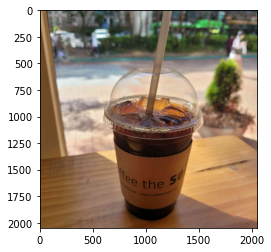

5, 싼 편은 아니지만 그만큼 맛있어요. 생크림이 달지 않아서 좋구요. 커피가 맛있습니다., distance : 0.0004826784133911133


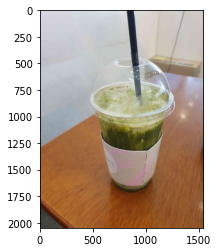

6, 여기 케잌 맛있습니다 오랜만에 달달한거 먹으려고 갔는데 모처럼 기분전환 됐어요 ㅋㅋㅋㅋ 점원분들도 친절하시고 설명도 자세히 해주셔서 감사했습니다. 하나만 먹으려고 했는데 너무 맛있어서 포장해왔어요~~, distance : 0.0005660653114318848


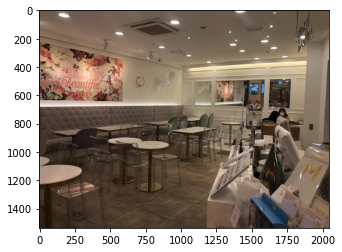

7, 찾아가는 길은 좀 힘들지만 외관도 예쁘고 커피도 맛있어요., distance : 0.0005705952644348145


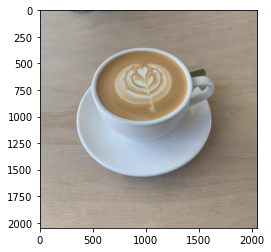

8, 해방촌 카페중에는 생긴지 오래되지않은 것 같은데 저녁에 뷰는 단연 좋았어요. 해질녘도 좋았는데 해지고 나서 조명 켜주니까 더 예뻐서 한참을 노을 쳐다봤네요. 사진이 더 잘 나와서 두둥 카페로 오길 잘했다는 생각이 들었습니다. 아메리카노가 아이스가 6,000원으로 조금 비싼 편이지만 뷰가 예쁘고 분위기가 좋아서 이해되는 가격이었어요. ㅎㅎ 맥주도 팔아서 맥주 한 잔 하기에도 좋은 분위기에요.

바로 앞에 유명한 카페가 있는데 거기의 앞쪽에 위치하고 있어서 루프탑에서 서로 보여요. 근데 두둥 카페가 더 앞에 있고 조명도 있어서 분위기는 더 나은 것 같아요, distance : 0.000632941722869873


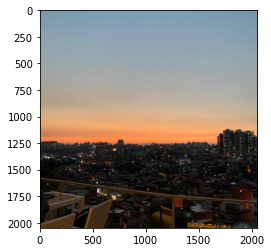

9, 완전 단골입니다. 아무데나 단골하는 사람은 아니구요 , 너무 친절하지도 너무 안친절하지도 않고 부담스럽지 않습니다. 편하게 갈 수 있고 맛은 가보시면 알아유 <U+0001F64C>, distance : 0.0006889104843139648


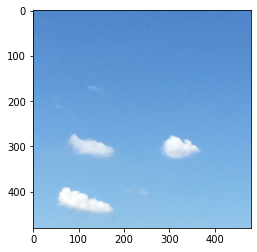

가장 먼 이미지
0, 처음마셔보는 보이나이티가 매력적이었고, 갤러리 느낌의 독특하고 넓직한 탁 트인 공간이었어요., distance : 1.5599792003631592


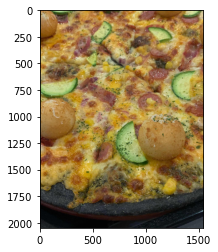

1, 아이스크림 와플은 처음이었는데 아이스크림 맛과 와플 맛, 초코맛까지 다 느껴져서 맛있었습니다!, distance : 1.5650620460510254


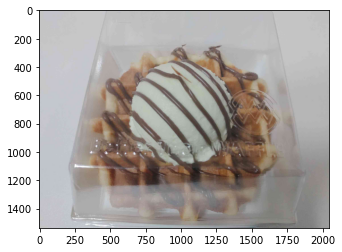

2, 뚱카롱을 메인으로 판매하는 가게. 다만 작은 케이크 형식의 디저트도 있어요. 일단 여느 뚱카롱이 그렇듯이 보기에 좋다는 장점이 있고, 맛도 나름 괜찮았습니다. 선물용으로 무난한 것 같아요., distance : 1.5733826160430908


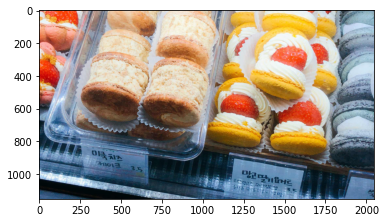

3, 카야토스트가 유명! 소문대로 맛있습니다. 주문은 키오스크에서 가능해요. 좁은 것 같지만 시끄러운 느낌은 아닙니다 ㅎㅎ, distance : 1.6132886409759521


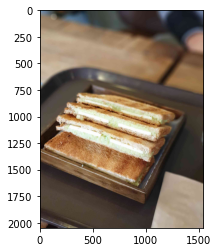

4, 커피를 캔에 담아주는 특이한 카페. 내부에 좌석은 바 좌석 뿐이고 협소해서 잠시 머무르는 정도로만 가능할듯. 밖에 테이블이 두개 있음., distance : 1.6658847332000732


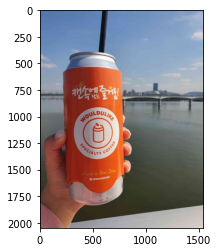

5, 녹사평을 내려다보는 경치 좋고 초코바나나 케익 아주 맛있고 그린 앤젤 티도 처음엔 사과 가향이 풍선껌 맛 같았다가 점점 녹차향이 나서 맛있었어요. 친절하시고 화장실도 깨끗 편리., distance : 1.6676409244537354


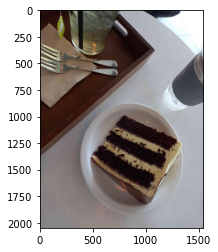

6, 여행정보를 얻을 수 있는 북카페예요. 대부분 여행책자가 구비되어 있어요, distance : 1.6983320713043213


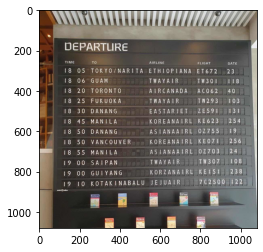

7, 시킨 메뉴 다 정성을 다해 만든 티가 나고 배도 부른 브런치 맛집을 발견했어요!
합정역 딜라이트스퀘어 건물에있는 브런치 집인데 메뉴가 다양하고 다 맛이 좋았어요
여럿이서 가서 메뉴를 네개시켜서 먹었는데 전부다 맛있었어요 ㅎㅎ 특히 구름 프렌치토스트는 일반프렌치토스트랑 조금 달라서 더 부드럽고 맛있었구 , 봉골레파스타도 파스타 전문점 같은 맛이었어요!

여럿이서가서 이 맛있는 메뉴들을 조금씩 먹어봐서 아주 만족했습니다. 데이트할때 가셔도좋고 여럿이서 모임으로 가서 메뉴 여러개 시켜놓고 나누어 먹어도 좋을 것 같아요. 매장도 자리가 다양하고 테이블 간에 먼편이에요 ㅎㅎ 매장 인테리어도 예쁘고 맛도 좋은 맛집입니다^^, distance : 1.7067458629608154


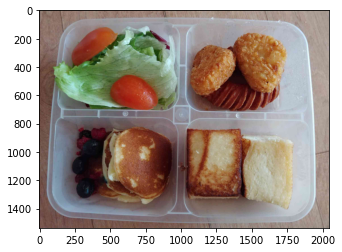

8, 화장실 불편한거 빼고 다좋아요, distance : 1.7448769807815552


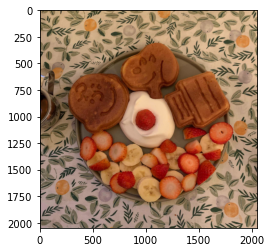

9, 성북동 카페.
조용하고 분위기가 앤틱함.
주차는 가게 앞에 공간에 하면 됨.
근처 방문시 들리는 카페!, distance : 1.7676975727081299


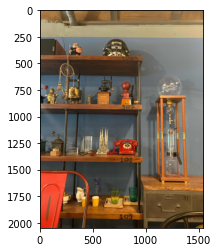

In [ ]:

# text embedding 을 한 것을 통해 target image와 가장 가까운 10개, 가장 먼 10개 보여주기
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
import matplotlib.pyplot as plt

tmp = np.array(embed_list).reshape(-1,1)
dist_mtx = euclidean_distances(tmp,tmp)

target_idx = 300

# 가장 가까운 것의 인덱스를 제공해준다
# ex target_idx가 200이라면, 첫 인덱스는 200
close_list = dist_mtx[target_idx].argsort()[0:10]
far_list = dist_mtx[target_idx].argsort()[-11:-1]

print(f"target img : {target_idx}")
img, rev = img_data[target_idx]
print(f"{i}, {rev}")
plt.imshow(img)
plt.show()


print("가장 가까운 이미지")
print("======================")
# target을 포함해 target과 가장 가까운 것 10개
for i, idx in enumerate(close_list):
    img, rev = img_data[idx]
    print(f"{i}, {rev}, distance : {dist_mtx[target_idx][idx]}")
    plt.imshow(img)
    plt.show()

print("가장 먼 이미지")
print("======================")
# target과 가장 먼것 10개
for i, idx in enumerate(far_list):
    img, rev = img_data[idx]
    print(f"{i}, {rev}, distance : {dist_mtx[target_idx][idx]}")
    plt.imshow(img)
    plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/trained_model/recsys_cafe')

target:  쉐프님이 운영하시는 브런치카페였으나, 커피와 와플만 먹고 왔어요.
알았는데, 츄러스는 맛있네용 맛있네용 진가를 진가를 진가를 추석때 추석때 추석때 좋아보였습니다!! 이거 찾아가볼만 디지털미디어시티역에는 북적거리지않고 디지털미디어시티역에는 티라미슈가 <PAD> 이거 동네카페 이상이었구요. 동네카페 체인점은 키즈층에 체인점은 

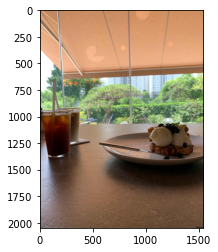

target:  쉐프님이 운영하시는 브런치카페였으나, 커피와 와플만 먹고 왔어요.
층보다 알았는데, (나중에 매너가 알았는데, 안예쁜데 진가를 추석때 추석때 안예쁜데 안예쁜데 안예쁜데 찻잔과 찾아가볼만 디지털미디어시티역에는 동네카페 동네카페 이거 이거 이거 인정하는데 키즈층에 <PAD> 아쉽네요ㅠ 이상이었구요. 

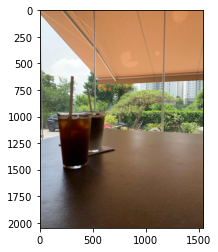

target:  조용한 술집입니다. 거리가 멀어서 그런 것 같기도 합니다. 고양이 3마리가 귀여워요
츄러스는 비싸긴 매너가 좋아보였습니다!! 매너가 (나중에 ㅂㅣㅅㅡㅋㅣㅅ, 엄 좋아보였습니다!! 키를 좋아보였습니다!! 좋아보였습니다!! 찻잔과 티라미슈가 원두맛이 키를 이상이었구요. 키를 원두맛이 이거 <PAD> 동네카페 체인점은 이상이었구요. <PAD> 

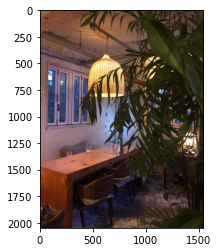

target:  조용한 술집입니다. 거리가 멀어서 그런 것 같기도 합니다. 고양이 3마리가 귀여워요
비싸긴 진가를 매너가 (나중에 알았는데, 매너가 좋아보였습니다!! 좋아보였습니다!! 추석때 엄 좋아보였습니다!! 좋아보였습니다!! 북적거리지않고 이거 북적거리지않고 동네카페 이상이었구요. 티라미슈가 인정하는데 인정하는데 <PAD> 키즈층에 그분들 감자빵같으면서도 아쉽네요ㅠ 

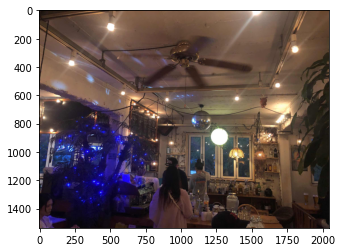

target:  조용한 술집입니다. 거리가 멀어서 그런 것 같기도 합니다. 고양이 3마리가 귀여워요
매너가 밋밋하지 알았는데, 비싸긴 추석때 ㅂㅣㅅㅡㅋㅣㅅ, 진가를 ㅂㅣㅅㅡㅋㅣㅅ, 진가를 ㅂㅣㅅㅡㅋㅣㅅ, 안예쁜데 북적거리지않고 북적거리지않고 북적거리지않고 북적거리지않고 북적거리지않고 북적거리지않고 키를 <PAD> <PAD> <PAD> 그분들 동네카페 이상이었구요. 인정하는데 

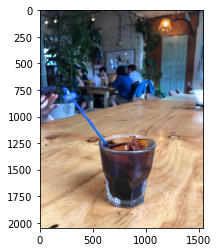

target:  너~~~~무 좋아요 일단 가격이 착합니다
4천원대의 음료를 보기힘들어요
커피외의 음료들도 가격이 괜찮습니다
가게내부는 넓진않지만 좁지도 않아요
자리가 한..15~20 개 정도 있습니다
가장비싸보이는 365커피시켰는데 약간 연유가 들어간 커피같기듀하고 스벅에 돌체라떼맛도 나구요
아메리카노는 2천원이여서 매일먹어도 부담없는 가격이에요 두명이서 사천원이라니... 맛도 괜찮았습니다
여기 옆에 카페 5개나 붙어있는데 저는 여기 추천할게요
알았는데, 매너가 매너가 (나중에 매너가 (나중에 매너가 진가를 좋아보였습니다!! 좋아보였습니다!! 좋아보였습니다!! 좋아보였습니다!! 좋아보였습니다!! 찻잔과 찻잔과 키를 원두맛이 감자빵같으면서도 이상이었구요. 감자빵같으면서도 체인점은 감자빵같으면서도 <PAD> 입에 인정하는데 

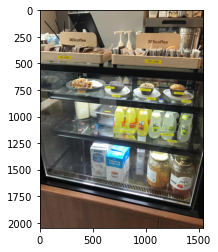

target:  너~~~~무 좋아요 일단 가격이 착합니다
4천원대의 음료를 보기힘들어요
커피외의 음료들도 가격이 괜찮습니다
가게내부는 넓진않지만 좁지도 않아요
자리가 한..15~20 개 정도 있습니다
가장비싸보이는 365커피시켰는데 약간 연유가 들어간 커피같기듀하고 스벅에 돌체라떼맛도 나구요
아메리카노는 2천원이여서 매일먹어도 부담없는 가격이에요 두명이서 사천원이라니... 맛도 괜찮았습니다
여기 옆에 카페 5개나 붙어있는데 저는 여기 추천할게요
맛있네용 비싸긴 비싸긴 비싸긴 추석때 진가를 ㅂㅣㅅㅡㅋㅣㅅ, ㅂㅣㅅㅡㅋㅣㅅ, 좋아보였습니다!! 디지털미디어시티역에는 안예쁜데 찻잔과 원두맛이 찻잔과 찻잔과 북적거리지않고 디지털미디어시티역에는 이거 <PAD> 이거 인정하는데 아쉽네요ㅠ <PAD> 인정하는데 키즈층에 

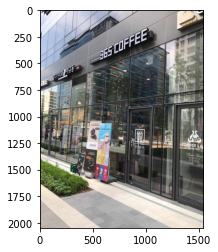

target:  너~~~~무 좋아요 일단 가격이 착합니다
4천원대의 음료를 보기힘들어요
커피외의 음료들도 가격이 괜찮습니다
가게내부는 넓진않지만 좁지도 않아요
자리가 한..15~20 개 정도 있습니다
가장비싸보이는 365커피시켰는데 약간 연유가 들어간 커피같기듀하고 스벅에 돌체라떼맛도 나구요
아메리카노는 2천원이여서 매일먹어도 부담없는 가격이에요 두명이서 사천원이라니... 맛도 괜찮았습니다
여기 옆에 카페 5개나 붙어있는데 저는 여기 추천할게요
밋밋하지 알았는데, 맛있네용 알았는데, 진가를 진가를 진가를 추석때 찻잔과 북적거리지않고 북적거리지않고 찾아가볼만 디지털미디어시티역에는 찾아가볼만 찾아가볼만 찾아가볼만 북적거리지않고 <PAD> 티라미슈가 키즈층에 키즈층에 이거 인정하는데 키즈층에 감자빵같으면서도 

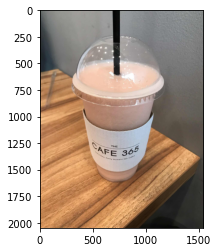

target:  깔끔하고 인테리어 예뻐요 여심저격 맛은 평타이상이긴 한데 엄청 맛잇는지는 모르겟음
비싸긴 비싸긴 (나중에 (나중에 알았는데, 찻잔과 (나중에 ㅂㅣㅅㅡㅋㅣㅅ, 찻잔과 찻잔과 엄 안예쁜데 찻잔과 디지털미디어시티역에는 키를 디지털미디어시티역에는 디지털미디어시티역에는 키를 키즈층에 이거 키즈층에 인정하는데 감자빵같으면서도 이상이었구요. 키즈층에 

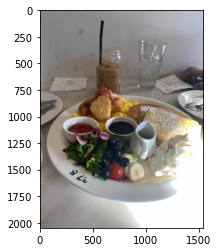

target:  깔끔하고 인테리어 예뻐요 여심저격 맛은 평타이상이긴 한데 엄청 맛잇는지는 모르겟음
층보다 밋밋하지 밋밋하지 추석때 ㅂㅣㅅㅡㅋㅣㅅ, 맛있네용 ㅂㅣㅅㅡㅋㅣㅅ, 찻잔과 추석때 안예쁜데 찾아가볼만 찻잔과 찾아가볼만 찾아가볼만 디지털미디어시티역에는 찾아가볼만 키즈층에 키를 키를 감자빵같으면서도 감자빵같으면서도 인정하는데 이상이었구요. 이상이었구요. 감자빵같으면서도 

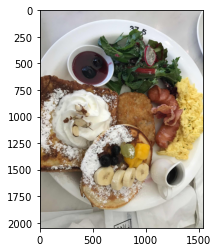

In [ ]:
for idx in range(55, 65):
  img, lab = train_data[idx]
  output = model(img.unsqueeze(0).to(device))

  img, rev = img_data[idx]
  print("target: ", rev)
  plt.imshow(img)

  print('==================')
  for i in output.argmax(1)[0]:
    print(model.vectorizer.idx2vocab[i.item()], end=' ')
  plt.show()

In [ ]:
for i in lab:
    print(model.vectorizer.idx2vocab[i.item()], end=' ')

깔끔하고 인테리어 예뻐요 여심저격 맛은 평타이상이긴 한데 엄청 맛잇는지는 모르겟음 <UNK> <UNK> <UNK> <UNK> <UNK> 